In [60]:
from Discriminamometro import Utileria, Discriminamometro
import pandas as pd
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier


nlp = spacy.load('./data/tweets/')
# Se instancia la clase del Discriminamometro
obj_Discr = Discriminamometro('PRUEBA')

# Mostramos la cantidad de tweets
print(obj_Discr.nbr_TweetsXCorrida)

8


In [61]:
data = pd.read_csv("data/Tuits Discriminatorios - jul2020 - Muestra Tuits.csv")

In [62]:
data.columns = ['full_text', 'categoria', 'disc', 'Observaciones']
data["disc"] = data["disc"].replace(['???'],'SI')

In [63]:
data["disc"].value_counts()

NO    631
SI    369
Name: disc, dtype: int64

In [64]:
data["disc"] = data["disc"].replace(['SI'],1)
data["disc"] = data["disc"].replace(['NO'],0)

In [65]:
data.head()

,full_text,categoria,disc,Observaciones
0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",apariencia,0,capaz que la imagen es discriminatoria
1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,apariencia,0,NaN
2,Hay momentos de la vida en los que te das cuen...,apariencia,0,NaN
3,@hornyboysmex @Hombres_sexgay Hermoso guerito !,apariencia,0,sextuiter es un mundo raro
4,Que restriccion tiene @DrGiammattei preparado ...,apariencia,0,NaN


In [66]:
obj_Discr.str_StopWords='StopWords.p'
obj_Discr.CargarStopWords()

data = obj_Discr.LimpiarDataFrame(data)
data = obj_Discr.QuitarStopWordsDataFrame(data)

In [67]:
train, test = train_test_split(data, test_size=0.2)

In [68]:
npEmbeddings = np.empty([0, 300])

for texto in train['full_text']:
    
    #print(texto)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    if doc.vector.shape[0]==300:
        npEmbeddings = np.append(npEmbeddings, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)

npEmbeddings.shape

(800, 300)

In [69]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import pandas as pd
import os

In [70]:
def Correr_Magic_Loop( npClassifier, npDictHyperParams, X_train, Y_train, nbrCv, strScoring):

        npResultados = np.array([])
        for i, classifier in enumerate(npClassifier):
            dictHyperParams = npDictHyperParams[i]
            grid_search = GridSearchCV(classifier,
                                       dictHyperParams,
                                       scoring=strScoring,
                                       cv=nbrCv,
                                       n_jobs=-1,
                                       verbose=3
                                       )
            grid_search.fit(X_train, Y_train)
            npResultados = np.append(npResultados, grid_search)

            # de los valores posibles que pusimos en el grid, cuáles fueron los mejores
            print('grid_search.best_params_: ', grid_search.best_params_)

            # mejor score asociado a los modelos generados con los diferentes hiperparametros
            # corresponde al promedio de los scores generados con los cv
            print('grid_search.best_score_: ', grid_search.best_score_)

            best_model = grid_search.best_estimator_


        return best_model, npResultados

In [71]:
def Prep_Modelos(npModelos):

    npArrayModelos = np.array([])
    for strModelo in npModelos:

        if strModelo == 'DECTREE':
            classifier = tree.DecisionTreeClassifier()
        if strModelo == 'RANDOMF':
            classifier = RandomForestClassifier()
        if strModelo == 'XGBOOST':
            classifier = GradientBoostingClassifier()

        npArrayModelos = np.append(npArrayModelos, classifier)

    return npArrayModelos

In [72]:
npDictHiperParam = np.array([]) 
# Parametrización para Árboles
dictHyperParams = {'max_depth': [4,7],  # 
                   'min_samples_split': [4,16],  # 
                   'min_samples_leaf': [3,7],  # 
                   'max_features': ['sqrt','log2']  # 
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Parametrización para Bosques
dictHyperParams = {'n_estimators': [50],  # Se redujo a 50
                   'max_depth': [4,7],  # 
                   'max_features': ['sqrt','log2'],
                   'min_samples_split': [4,16],
                   'min_samples_leaf': [3,7]
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Parametrización para XGBoost
dictHyperParams = {'learning_rate': [0.1,0.25, 0.75],
                   'n_estimators': [50,100,150],  # Se redujo a 50
                   'min_samples_split': [4,16],
                   'min_samples_leaf': [3,7],
                   'max_depth': [3,4,5,6,7,10,15],
                   'max_features': ['sqrt','log2']
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Se crean los modelos de clasificaión que se emplearán (en el mismo orden que los diccionarios)
npNombreModelos = np.array([])
npNombreModelos = np.append(npNombreModelos, 'DECTREE')
npNombreModelos = np.append(npNombreModelos, 'RANDOMF')
npNombreModelos = np.append(npNombreModelos, 'XGBOOST')

In [73]:
X_train = pd.DataFrame(npEmbeddings)
Y_train = pd.DataFrame(train.disc)
arrModelos = Prep_Modelos(npNombreModelos)

# #Se corre el magic loop para realizar las predicciones con los parámetros previamente establecidos
best_model,npGridSearchCv = Correr_Magic_Loop(arrModelos,
                                    npDictHiperParam,
                                    X_train,
                                    Y_train,
                                    5,
                                    'roc_auc')

npArrBestScores = np.array([])
npArrBestParams = np.array([])

# Barremos el arreglo de GridSearchCV´s para sacar los mejores scores y parámetros
for grid in npGridSearchCv:
    npArrBestScores = np.append(npArrBestScores, grid.best_score_)
    npArrBestParams = np.append(npArrBestParams, grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [15]:
# Obtenemos el índice del mejor score
nbrIndiceGanador = np.argmax(npArrBestScores, axis=0)

# Mostramos el modelo, parámetros y score ganador
# print("Modelo ganador: \n", arrModelos[nbrIndiceGanador])
# print("Score del modelo ganador: \n", npArrBestScores[nbrIndiceGanador])
# print("Parametros del modelo ganador: \n", npArrBestParams[nbrIndiceGanador])

# Se instancia el modelo ganador
# self.ModeloGanadorMagicLoop = objEda.InstanciarModeloDinamico(npNombreModelos, nbrIndiceGanador, npArrBestParams[nbrIndiceGanador])
ModeloGanadorMagicLoop = best_model

In [16]:
ModeloGanadorMagicLoop

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Desempeño en test

In [18]:
npEmbeddings2 = np.empty([0, 300])
for texto in test['full_text']:
    
    #print(frase)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    #print(npEmbeddings.shape)
    #print(doc.vector.shape)
    
    if doc.vector.shape[0]==300:
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        doc = nlp('prueba')
        #npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
        predicted_svm = clf.predict([doc.vector])
        
npEmbeddings2.shape

(200, 300)

In [27]:
predicted_svm = best_model.predict(npEmbeddings2)
np.mean(predicted_svm == test.disc)

0.775

In [20]:
npAux = nlp('malditos amlovers culeros').vector
predicted_svm = best_model.predict([npAux])
predicted_svm

array([1])

In [23]:

################### Carga de parámetros
import pickle as pickle

pickleFile = open('modelo_clasificacion_binaria.p', 'rb')
modelo2 = pickle.load(pickleFile)
pickleFile.close()

In [78]:
y_probas = best_model.predict_proba(npEmbeddings2)
y_true = test.disc
y_prob = pd.DataFrame(y_probas)
y_prob.columns = ["cero","uno"]
y_prob = y_prob["uno"]

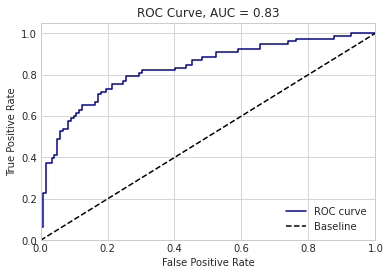

In [79]:
from sklearn import metrics
from matplotlib import pyplot as plt 

#Definimos la funcion que graficará la ROC
def plot_ROC(test_labels, test_predictions):
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, 
                                             test_predictions, pos_label=1)
    auc = "%.2f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    with plt.style.context(('seaborn-whitegrid')):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "#000099", label='ROC curve')
        ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.title(title)
    return  
plot_ROC(y_true, y_prob) 

# Prueba de categorías

In [12]:
data = pd.read_csv("tweets_julio_embeddings.csv")
data

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,full_text,categoria
0,0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",apariencia
1,1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,apariencia
2,3,Hay momentos de la vida en los que te das cue...,apariencia
3,4,@hornyboysmex @Hombres_sexgay Hermoso guerito !,apariencia
4,5,Que restriccion tiene @DrGiammattei preparado ...,apariencia
...,...,...,...
3160328,360,@tamairycabrera Esa fue tu cara. https://t.co/...,neutro
3160329,361,no me voy a cansar de felicitar a todos los qu...,neutro
3160330,362,@CESARRRASCON Se mueren porque se encuentre al...,neutro
3160331,363,Las ganas son grandes bruh,neutro


In [13]:
data["categoria"] = data["categoria"].replace(['apariencia'],1)
data["categoria"] = data["categoria"].replace(['discapacidad'],2)
data["categoria"] = data["categoria"].replace(['edad'],3)
data["categoria"] = data["categoria"].replace(['genero'],4)
data["categoria"] = data["categoria"].replace(['ideologia'],5)
data["categoria"] = data["categoria"].replace(['orientacion'],6)
data["categoria"] = data["categoria"].replace(['religion'],7)
data["categoria"] = data["categoria"].replace(['neutro'],8)
data

,Unnamed: 0,full_text,categoria
0,0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",1.0
1,1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,1.0
2,3,Hay momentos de la vida en los que te das cue...,1.0
3,4,@hornyboysmex @Hombres_sexgay Hermoso guerito !,1.0
4,5,Que restriccion tiene @DrGiammattei preparado ...,1.0
...,...,...,...
3160328,360,@tamairycabrera Esa fue tu cara. https://t.co/...,8.0
3160329,361,no me voy a cansar de felicitar a todos los qu...,8.0
3160330,362,@CESARRRASCON Se mueren porque se encuentre al...,8.0
3160331,363,Las ganas son grandes bruh,8.0


In [14]:
data = data[data["categoria"].isnull()==False]
data

,Unnamed: 0,full_text,categoria
0,0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",1.0
1,1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,1.0
2,3,Hay momentos de la vida en los que te das cue...,1.0
3,4,@hornyboysmex @Hombres_sexgay Hermoso guerito !,1.0
4,5,Que restriccion tiene @DrGiammattei preparado ...,1.0
...,...,...,...
3160328,360,@tamairycabrera Esa fue tu cara. https://t.co/...,8.0
3160329,361,no me voy a cansar de felicitar a todos los qu...,8.0
3160330,362,@CESARRRASCON Se mueren porque se encuentre al...,8.0
3160331,363,Las ganas son grandes bruh,8.0


In [15]:
from sklearn.utils import shuffle
data = shuffle(data)
data

,Unnamed: 0,full_text,categoria
1262938,188,TURBULENTOS ASPIRANTES MEXIQUESES AL INE. Doy ...,8.0
1263106,57,Quien sera el hombre que aguante mis dramas ?,8.0
251647,4,@martinezmau Ufff asi se calla el hocico chair...,5.0
1328352,286,COMBATIMOS Y VENCEMOS EN VENEZUELA Y EL MUNDO...,8.0
192517,90,@CDBadajoz Que asco de filiales. Algo habria q...,4.0
...,...,...,...
1149119,48,unas ganas de desayunar papas fritas,8.0
245486,32,@arturo1180 @ahoraonuncaespn @mauriciopedroza ...,5.0
295675,19,Me puedo quejar de muchas cosas (validas) pero...,6.0
1342823,225,Los momentos se miden en sonrisas no en numero...,8.0


In [16]:
data = data.iloc[0:100]
data

,Unnamed: 0,full_text,categoria
1262938,188,TURBULENTOS ASPIRANTES MEXIQUESES AL INE. Doy ...,8.0
1263106,57,Quien sera el hombre que aguante mis dramas ?,8.0
251647,4,@martinezmau Ufff asi se calla el hocico chair...,5.0
1328352,286,COMBATIMOS Y VENCEMOS EN VENEZUELA Y EL MUNDO...,8.0
192517,90,@CDBadajoz Que asco de filiales. Algo habria q...,4.0
...,...,...,...
33793,2,"@AntiBotsHN Farsante de mierda, nadie es mas c...",2.0
1255001,34,"Nogales, Sonora, Mexico, 1979 (c) Alex Webb, E...",8.0
310940,33,Si me encuentran colgado el.dia de hoy culpo d...,6.0
1279131,15,El Centro de Transferencia Canina ha recibido ...,8.0


In [17]:
obj_Discr.str_StopWords='StopWords.p'
obj_Discr.CargarStopWords()

data = obj_Discr.LimpiarDataFrame(data)
data = obj_Discr.QuitarStopWordsDataFrame(data)

In [18]:
train, test = train_test_split(data, test_size=0.2)
print(train.shape)
print(test.shape)

(80, 3)
(20, 3)


In [19]:
npEmbeddings = np.empty([0, 300])

for texto in train['full_text']:
    
    #print(texto)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    if doc.vector.shape[0]==300:
        npEmbeddings = np.append(npEmbeddings, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)

npEmbeddings.shape

(80, 300)

In [106]:
# Import pandas library 
import pandas as pd 
  
# initialize list of lists 
data = [[34, 10, 54,  98, 1], [78, 15,54, 88, 1], [74, 14, 10, 65, 1], [744, 134, 110, 645, 1], [734, 434, 610, 675, 1],
        [9, 41, 10, 63, 2], [9, 41, 10, 63, 2], [91, 21, 103, 43, 2], [98, 461, 103, 683, 2], [741, 13, 114, 642, 2],
        [19, 441, 145, 66, 3], [91, 481, 140, 623, 3], [29, 441, 150, 634, 3], [294, 440, 160, 634, 3], [74, 13, 11, 145, 3]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['A', 'B', 'C', 'D', 'Y']) 
  
X_train = df[['A','B','C','D']]
Y_train = df[['Y']]

# print dataframe. 
df

,A,B,C,D,Y
0,34,10,54,98,1
1,78,15,54,88,1
2,74,14,10,65,1
3,744,134,110,645,1
4,734,434,610,675,1
5,9,41,10,63,2
6,9,41,10,63,2
7,91,21,103,43,2
8,98,461,103,683,2
9,741,13,114,642,2


In [108]:
train, test = train_test_split(df, test_size=0.5)
print(train.shape)
print(test.shape)

(7, 5)
(8, 5)


In [109]:
#X_train = pd.DataFrame(npEmbeddings)
#Y_train = pd.DataFrame(train.disc)
arrModelos = Prep_Modelos(npNombreModelos)

# #Se corre el magic loop para realizar las predicciones con los parámetros previamente establecidos
best_model,npGridSearchCv = Correr_Magic_Loop(arrModelos,
                                    npDictHiperParam,
                                    X_train,
                                    Y_train,
                                    2,
                                    'accuracy')

npArrBestScores = np.array([])
npArrBestParams = np.array([])

# Barremos el arreglo de GridSearchCV´s para sacar los mejores scores y parámetros
for grid in npGridSearchCv:
    npArrBestScores = np.append(npArrBestScores, grid.best_score_)
    npArrBestParams = np.append(npArrBestParams, grid.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
grid_search.best_params_:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 16}
grid_search.best_score_:  0.26785714285714285
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    1.3s finished
/home/jupyter-ronmoy007@gmail.co-0e856/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


grid_search.best_params_:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 50}
grid_search.best_score_:  0.26785714285714285
Fitting 2 folds for each of 504 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   35.3s


grid_search.best_params_:  {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 50}
grid_search.best_score_:  0.3839285714285714


[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  1.1min finished
/home/jupyter-ronmoy007@gmail.co-0e856/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [110]:
# Obtenemos el índice del mejor score
nbrIndiceGanador = np.argmax(npArrBestScores, axis=0)

# Mostramos el modelo, parámetros y score ganador
# print("Modelo ganador: \n", arrModelos[nbrIndiceGanador])
# print("Score del modelo ganador: \n", npArrBestScores[nbrIndiceGanador])
# print("Parametros del modelo ganador: \n", npArrBestParams[nbrIndiceGanador])

# Se instancia el modelo ganador
# self.ModeloGanadorMagicLoop = objEda.InstanciarModeloDinamico(npNombreModelos, nbrIndiceGanador, npArrBestParams[nbrIndiceGanador])
ModeloGanadorMagicLoop = best_model
ModeloGanadorMagicLoop

GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=3,
                           min_samples_split=4, n_estimators=50)

# Test

In [ ]:
npEmbeddings2 = np.empty([0, 300])
for texto in test['full_text']:
    
    #print(frase)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    #print(npEmbeddings.shape)
    #print(doc.vector.shape)
    
    if doc.vector.shape[0]==300:
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        doc = nlp('prueba')
        #npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
        predicted_svm = clf.predict([doc.vector])
        
npEmbeddings2.shape

In [111]:
classifier = ModeloGanadorMagicLoop
X_test = test[['A','B','C','D']]
y_test = test.Y
class_names = ['clase1','clase2','clase3']

Confusion matrix, without normalization
[[1 0 0]
 [0 3 0]
 [0 0 4]]
Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


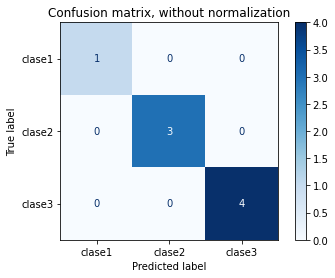

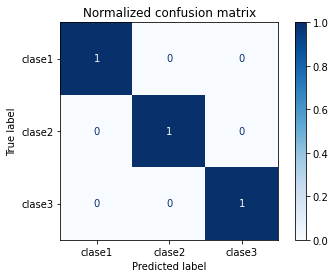

In [112]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()